Klasterovanje - tehnika nenadgledanog učenja čiji je cilj da se objekti grupišu tako da su slični unutar klastera, a različiti između klastera.

Podela algoritama klasterovanja zasnovana na principu na kojem rade:

**1) Particioni algoritmi** - dele na K unapred definisanih klastera gde svala instanca pripada tačno jednom klasteru. Pripadnost instance nekom klasteru odredjuje se tako da minimuje neku funkciju (na primer minimiyacija udaljenosti od centra klastera)

**K-Means**:
- unapred se zada broj klastera K i nasumično se izaberu K centara (centroida),
- sve dok ne bude zadovoljen uslov zaustavljanja:

  - svaki podatak se dodeljuje najbližem centroidu (najčešće Euklidska distanca),
  - za svaki klaster se računa novi centroid (aritmetička sredina tačaka koje pripadaju tom klasteru)
- algoritam se zaustavlja kada se centroidi više ne manjaju do na neku tačnost
- cilj je minimizacija sume kvadrata udaljenosti tačaka od centroida

https://www.youtube.com/watch?v=4E_DFMt60rc

**K-Means++**:
- unapred se zada broj klastera K, ali ključna razlika u odnosu na običan K-Means je što se u ovom algoritmu ne koristi nasumično biranje početnih centroida. Prvi centroid se bira nasumično, ali se svaki sledeći bira sa verovatnoćom proporcionalnom kvadratu udaljenosti od najbližeg već izabranog centroida što daje bolju raspoređenost centorida na početku
- prednost ovog algoritma u odnosu na običan jee brža konvergencija, veća stabilnost i obično bolje klasterovani podaci.

In [22]:
import pandas as pd
import numpy as np
from sklearn import datasets
import matplotlib.pyplot as plt

In [23]:
data = datasets.load_iris() # vraca objekat koji sadrzi:
# data -> NumPy niz koji sadrzi vrednosti atributa
# target -> NumPy niz koji sadrži klase
# feature_names -> Lista imena atributa

columns = np.array(data.feature_names)
print(columns)
X = data.data 
print(X.shape)
y = data.target
print(y.shape)

data_values = np.concatenate((X, y.reshape((y.shape[0], 1))), axis=1)
iris_df = pd.DataFrame(data=data_values, columns=[col for col in columns] + ['class'])

['sepal length (cm)' 'sepal width (cm)' 'petal length (cm)'
 'petal width (cm)']
(150, 4)
(150,)


In [24]:
from sklearn.preprocessing import StandardScaler # zbog racunanja distanci
X_scaled = StandardScaler().fit_transform(X)

In [25]:
from sklearn.decomposition import PCA
pca = PCA()
X_pca = pca.fit_transform(X_scaled)

In [26]:

from sklearn.cluster import KMeans
km = KMeans(n_clusters=3,n_init=100, max_iter=500, init='random') # parametar init podesava {‘k-means++’, ‘random’}
km.fit(X_scaled)

,"n_clusters n_clusters: int, default=8The number of clusters to form as well as the number ofcentroids to generate.For an example of how to choose an optimal value for `n_clusters` refer to:ref:`sphx_glr_auto_examples_cluster_plot_kmeans_silhouette_analysis.py`.",3
,"init init: {'k-means++', 'random'}, callable or array-like of shape (n_clusters, n_features), default='k-means++'Method for initialization:* 'k-means++' : selects initial cluster centroids using sampling based on an empirical probability distribution of the points' contribution to the overall inertia. This technique speeds up convergence. The algorithm implemented is ""greedy k-means++"". It differs from the vanilla k-means++ by making several trials at each sampling step and choosing the best centroid among them.* 'random': choose `n_clusters` observations (rows) at random from data for the initial centroids.* If an array is passed, it should be of shape (n_clusters, n_features) and gives the initial centers.* If a callable is passed, it should take arguments X, n_clusters and a random state and return an initialization.For an example of how to use the different `init` strategies, see:ref:`sphx_glr_auto_examples_cluster_plot_kmeans_digits.py`.For an evaluation of the impact of initialization, see the example:ref:`sphx_glr_auto_examples_cluster_plot_kmeans_stability_low_dim_dense.py`.",'random'
,"n_init n_init: 'auto' or int, default='auto'Number of times the k-means algorithm is run with different centroidseeds. The final results is the best output of `n_init` consecutive runsin terms of inertia. Several runs are recommended for sparsehigh-dimensional problems (see :ref:`kmeans_sparse_high_dim`).When `n_init='auto'`, the number of runs depends on the value of init:10 if using `init='random'` or `init` is a callable;1 if using `init='k-means++'` or `init` is an array-like... versionadded:: 1.2 Added 'auto' option for `n_init`... versionchanged:: 1.4 Default value for `n_init` changed to `'auto'`.",100
,"max_iter max_iter: int, default=300Maximum number of iterations of the k-means algorithm for asingle run.",500
,"tol tol: float, default=1e-4Relative tolerance with regards to Frobenius norm of the differencein the cluster centers of two consecutive iterations to declareconvergence.",0.0001
,"verbose verbose: int, default=0Verbosity mode.",0
,"random_state random_state: int, RandomState instance or None, default=NoneDetermines random number generation for centroid initialization. Usean int to make the randomness deterministic.See :term:`Glossary `.",None
,"copy_x copy_x: bool, default=TrueWhen pre-computing distances it is more numerically accurate to centerthe data first. If copy_x is True (default), then the original data isnot modified. If False, the original data is modified, and put backbefore the function returns, but small numerical differences may beintroduced by subtracting and then adding the data mean. Note that ifthe original data is not C-contiguous, a copy will be made even ifcopy_x is False. If the original data is sparse, but not in CSR format,a copy will be made even if copy_x is False.",True
,"algorithm algorithm: {""lloyd"", ""elkan""}, default=""lloyd""K-means algorithm to use. The classical EM-style algorithm is `""lloyd""`.The `""elkan""` variation can be more efficient on some datasets withwell-defined clusters, by using the triangle inequality. However it'smore memory intensive due to the allocation of an extra array of shape`(n_samples, n_clusters)`... versionchanged:: 0.18 Added Elkan algorithm.. versionchanged:: 1.1 Renamed ""full"" to ""lloyd"", and deprecated ""auto"" and ""full"". Changed ""auto"" to use ""lloyd"" instead of ""elkan"".",'lloyd'


In [27]:
print(km.cluster_centers_)

centroids = pca.transform(km.cluster_centers_)
print(centroids)

[[ 1.13597027  0.08842168  0.99615451  1.01752612]
 [-0.05021989 -0.88337647  0.34773781  0.2815273 ]
 [-1.01457897  0.85326268 -1.30498732 -1.25489349]]
[[ 1.72103664  0.60288719  0.00882843 -0.020299  ]
 [ 0.57262144 -0.80720888 -0.04824323  0.0353036 ]
 [-2.22475316  0.28892745  0.0428391  -0.01834076]]


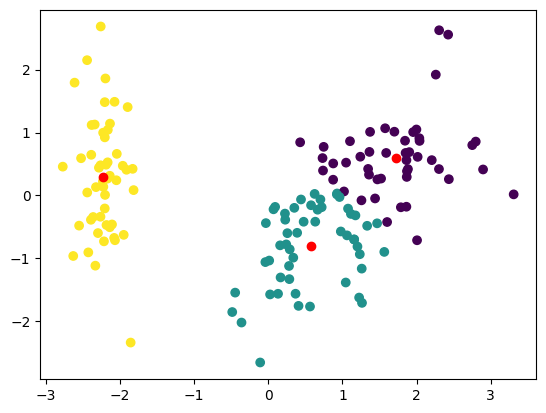

In [28]:
plt.scatter(X_pca[:,0],X_pca[:,1],c=km.labels_)
plt.scatter(centroids[:,0],centroids[:,1],c='red')

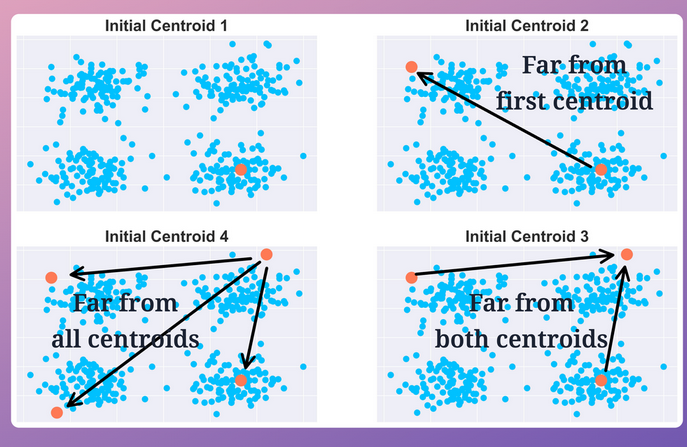

**K-Medoids**:
- unapred se zada broj klastera K, ali ključna razlika u odnosu na prethodna dva algoritma je što se ovde biraju realne tačke iz skupa (medoidi)
- sve dok ne bude zadovoljen uslov zaustavljanja:

  - svaki podatak se dodeljuje najbližem medoidu (najčešće Euklidska distanca),
  - za svaki klaster se računa nova tačka iy skupa (medoid) koja mimiyuje sumu udaljenosti unutar klastera
- algoritam se zaustavlja kada se medoidi više ne manjaju

- prednost ovog algoritma je što je interpretabilniji i robustniji na outliere (jer centroid je aritmetička sredina svih tačaka u klasteru što znaci da svaka tačka utiče na centroid, bez obzira koliko je daleko i  ako se pojavi jedan ekstremno udaljen outlier on značajno pomera centroid. Kod medoida dalja tačka nikada neće biti izabrana za medoid jer onda ima veliku sumu udaljenosti)

https://youtu.be/OFELCn-6r2o?t=59

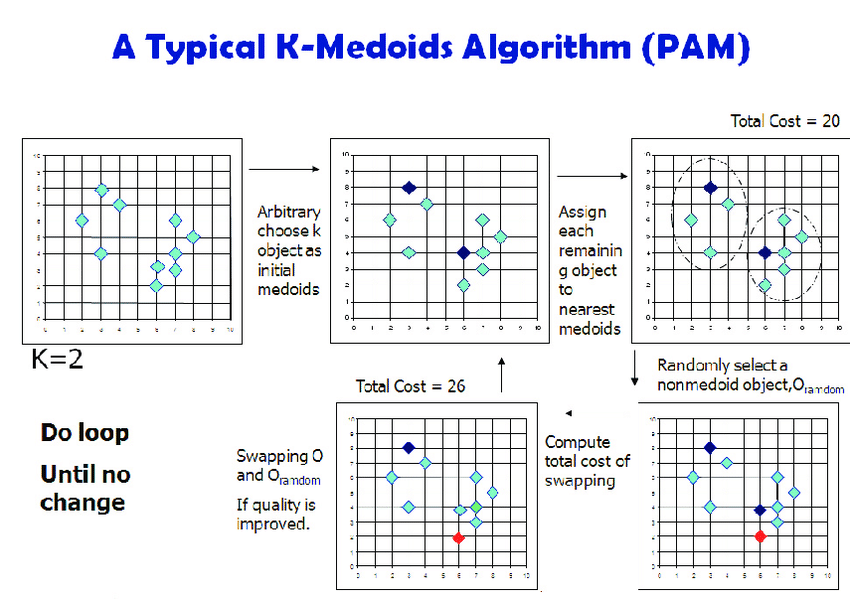

Kako izabrati K?

***Metod lakta (Elbow method)*** koristi se za određivanje optimalnog broja klastera k posmatranjem kako se menja greška klasterovanja u zavisnosti od k. Pokrene se algoritam za različite vrednosti k i onda se za svako k izračuna suma kvadrata udaljenosti tačaka od pripadajućeg centroida. Na kraju se idcrta graf gde na x-osi imamo broj klastera k, dok na y-osi imamo WCSS. Vrednost k u „laktu“ predstavlja najbolji kompromis između složenosti modela (više klastera) i kvaliteta klasterovanja (manja greška).

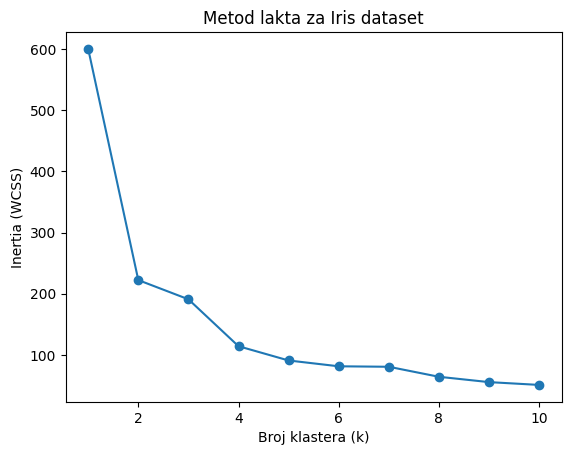

In [29]:
inertia = []
K = range(1, 11)

for k in K:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X_scaled)
    inertia.append(kmeans.inertia_)

plt.figure()
plt.plot(K, inertia, marker='o')
plt.xlabel('Broj klastera (k)')
plt.ylabel('Inertia (WCSS)')
plt.title('Metod lakta za Iris dataset')
plt.show()

***Silueta skor***

Za svaku instancu X:
- A = izračunava se kao prosečna udaljenost od svih instanci iz klastera u kojem se nalazi instanca X.
- B = izačunava se kao prosečna udaljenost od svih instanci iz najbližeg klastera klasteru u kojem se nalazi instanca X.

Silueta instance X se izačunava kao : (B-A)/max(B,A)

Ukupna silueta klasterovanja izračunava se kao prosečna vrednost silueti svih instanci.

Ukoliko je za sve instance, vrednost B mnogo veća nego vrednost A, to bi značilo da je:
- prosečna udaljenost velika između klastera u kojem se instanca nalazi i najbližeg njenog klastera
- prosešna udaljenost između instanci iz istog klastera mala

Iz čega se zaključuje da je ukupna silueta bliska 1, što znači da su podaci u istim klasterima mnogo sličniji nego onim u ostalim klasterima.

Problem: kvadratna složenost izračunavanja u odnosu na broj instanci

In [35]:
from sklearn.metrics import silhouette_score
silhouettes = []
for n in range(2,10):
    km = KMeans(n_clusters=n,n_init=100, max_iter=500, init='random')
    km.fit(X_scaled)
    s = silhouette_score(X_scaled, km.labels_, metric='euclidean')
    silhouettes.append(s)

silhouettes

[0.5817500491982808,
 0.45994823920518635,
 0.3844714602625276,
 0.34551099599809465,
 0.3256773128015377,
 0.32544607281971444,
 0.3333276510085405,
 0.3307093340510728]

<StemContainer object of 3 artists>

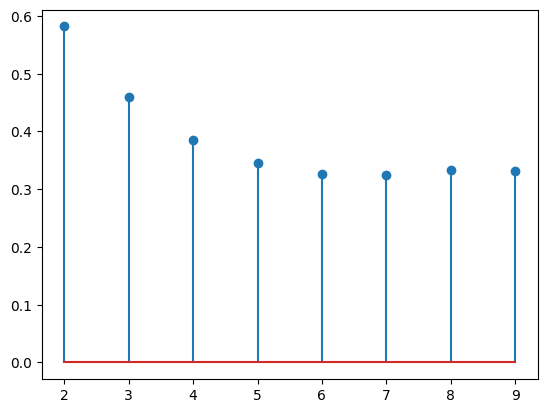

In [36]:
plt.stem(range(2,10),silhouettes)

Optimalan broj klastera bi bio 2, ali znamo da se u nasim podacima nalaze 3 razlicite grupe podataka (posledica toga sto su Versicolor i Verginica jako slicne)

***Calinski-Harabasz indeks*** (Variance Ratio Criterion)

Izračunava se kao A/B, gde je:
- A = suma kvadriranih rastojanja izmedju svih centroida i centra celog dataseta
- B = suma kvadriranih rastojanja izmedju instanci i njihovog pridruženog centroida klastera

Vrednost A je mnogo veća od B:
- Udaljenost centroida od centra dataseta je velika
- Udaljenost između instanci i njihovih centroida je mala

Iz čega se zaključuje da je Calinski-Harabasz indeks visok, što znači da su klasteri dobro razdvojeni, dok niže vrednosti mogu sugerisati da su klasteri blizu jedni drugima, što može izazvati sumnju u kvalitet klasterovanja

Mnogo se brže izračunava nego Silueata, a ima istu intuiciju.

In [38]:
from sklearn.metrics import calinski_harabasz_score
km = KMeans(n_clusters=3,n_init=100, max_iter=500, init='random')
km.fit(X_scaled)
calinski_harabasz_score(X_scaled, km.labels_)

241.90440170183157

**2) Algoritmi zasnovani na hijerarhiji** - grade strukturu klastera u obliku stabla ili dendograma. Postoje dva pristupa spajanja bottom-up i top-down, gde u svakom pristupu imamo više načina na koji spajamo/razdvajamo klastere:
- single linkage - najbliže tačke
- complete linkage - najudaljenije tačke
- average linkage - prosečna udaljenost
- ward metoda - minimizuje porast varijanse (najčešći u praksi)

Nisu dobri za velike skupove podataka.

**Aglomerativni (bottom-up) klasterovanje** - kreće se od toga da je svaki objekat zaseban klaster pa se u svakoj iteraciji spajaju najbliži klasteri, sve dok sve instance ne pripadnu jednom klasteru

Primena: za vizuelnu reprezentaciju (dendogram) i da se oceni koliko klastera imamo

In [10]:
from sklearn.preprocessing import StandardScaler # zbog racunanja distanci
X_scaled = StandardScaler().fit_transform(X)

In [44]:
from sklearn.decomposition import PCA
pca = PCA()
X_pca = pca.fit_transform(X_scaled)

In [57]:
from sklearn.cluster import  AgglomerativeClustering
#ac = AgglomerativeClustering(n_clusters=None, distance_threshold=0, linkage='ward') # ukoliko žqlimo potpuno klasterovanje kako bismo iscrtali dendogram
                                                            # i sami odredili broj klastera
# linkage moze biti 'single', 'complete', 'average', 'ward'
# napomena: uz 'ward' vezu mozemo koristiti samo Euklidsku distancu koja je podrazumevana za parametar metric



ac = AgglomerativeClustering(n_clusters=3, linkage='ward')
ac_fitted_data = ac.fit(X_scaled)

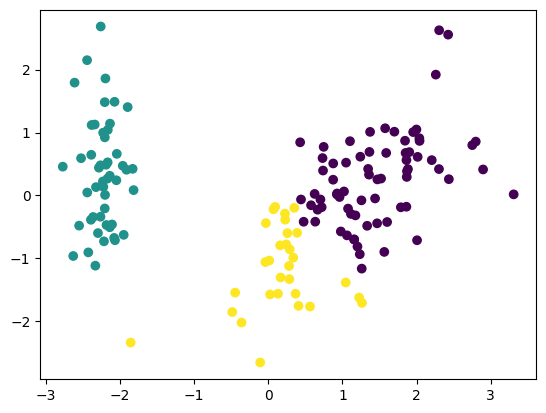

In [121]:
plt.scatter(X_pca[:,0], X_pca[:,1], c=ac.labels_)

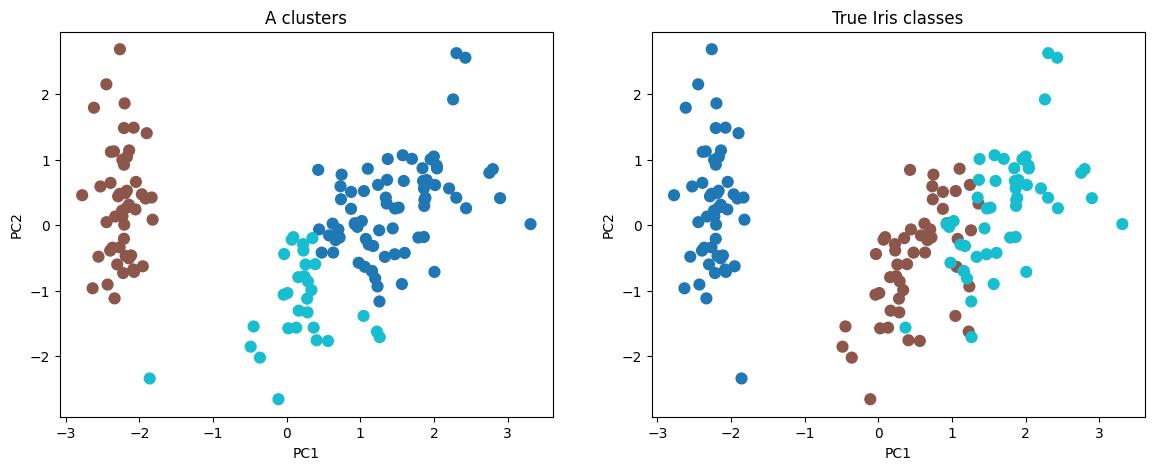

In [122]:
plt.figure(figsize=(14, 5))

#Klasteri
plt.subplot(1, 2, 1)
plt.scatter(
    X_pca[:, 0],
    X_pca[:, 1],
    c=ac.labels_,
    cmap="tab10",
    s=60
)
plt.title("A clusters")
plt.xlabel("PC1")
plt.ylabel("PC2")

# Prave klase
plt.subplot(1, 2, 2)
plt.scatter(
    X_pca[:, 0],
    X_pca[:, 1],
    c=pd.Categorical(y).codes,
    cmap="tab10",
    s=60
)
plt.title("True Iris classes")
plt.xlabel("PC1")
plt.ylabel("PC2")

plt.show()


Iscrtavanje dendograma.

Problem je sto AgglomerativeClustering ne vraća linkage matricu u kojoj svaki red znači jedno spajanje klastera oblika [cluster_1, cluster_2, distance, sample_count] gde su oznake:
- cluster_1, cluster_2 - indeksi klastera koji se spajaju
- distance - udaljenost pri spajanju
- sample_count - koliko originalnih uzoraka je u tom klasteru


U prvoj varijanti dendograma, koristi se funkcija koja ručno rekonstruiše linkage matricu iz već istreniranog sklearn modela, dok u drugoj varijanti se primaju sirovi podaci i racunaju se sve udaljenosti. 



In [47]:
from scipy.cluster.hierarchy import dendrogram

In [52]:
# Funkcija za crtanje dendrigrama
# preuzeta sa: https://scikit-learn.org/stable/auto_examples/cluster/plot_agglomerative_dendrogram.html
def plot_dendrogram(model, **kwargs):
    # Create linkage matrix and then plot the dendrogram

    # create the counts of samples under each node
    counts = np.zeros(model.children_.shape[0])
    n_samples = len(model.labels_)
    for i, merge in enumerate(model.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1  # leaf node
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count

    linkage_matrix = np.column_stack(
        [model.children_, model.distances_, counts]
    ).astype(float)

    # Plot the corresponding dendrogram
    dendrogram(linkage_matrix, **kwargs)

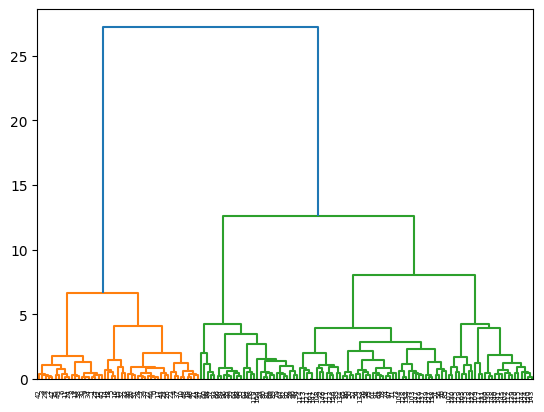

In [53]:
plot_dendrogram(ac_fitted_data)

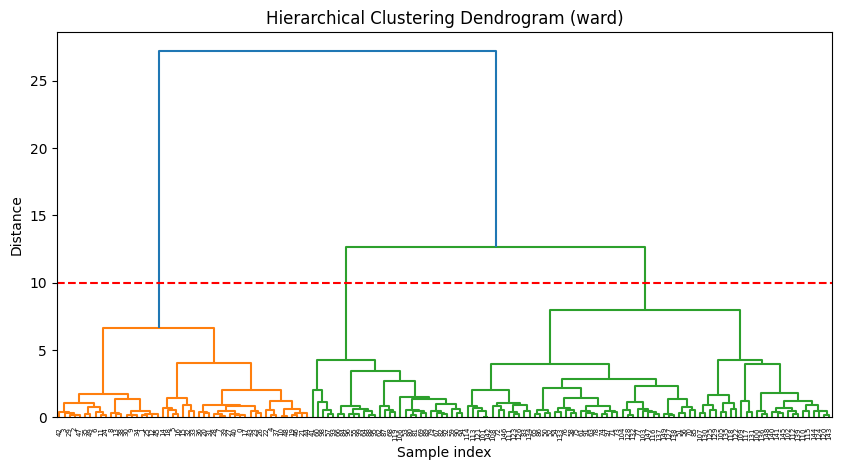

In [54]:
import matplotlib.pyplot as plt
from scipy.cluster.hierarchy import linkage

# linkage metoda u SciPy: 'single', 'complete', 'average', 'ward'
linkage_matrix = linkage(X_scaled, method="ward")

plt.figure(figsize=(10, 5))
dendrogram(linkage_matrix)  # no_labels=True ne prikazuje oznake na x osi 
                # truncate_mode="level" - iscrtava prvih p nivoa, dok "lastp" iscrtava poslednjih 5 nivoa
                # p=5 gde je  p=5 prikazuje prvih par nivoa da ne bude preveliko
            
plt.axhline(y=10.0, color="r", linestyle="--")
plt.title("Hierarchical Clustering Dendrogram (ward)")
plt.xlabel("Sample index")
plt.ylabel("Distance")
plt.show()

**Divizivni (top-down)** - kreće se od toga da svi objekti pripadaju jednom klasteru pa se u svakoj iteraciji vrši podela na više klastera.

Primena: kada u podacima znaš da postoje velike, grube grupe (npr. podela potrošača na male, srednje i velike), ali ne znamo unapred finije podgrupe unutar njih.

Bolji pristup jer greška prilikom spajanja dva klastera koji nisu slični se propagira do kraja u aglomerativnom klasterovanju, dok u deviznom greška ostaje lokalna.

**DIANA (Divisive Analysis)** je prvi i najpoznatiji formalni algoritam za top-down hijerarhijsko klasterovanje. Počinje sa jednim klasterom koji sadrži sve objekte i zatim ga iterativno deli na manje klastere tako sto računa disimilarnost svakog objekta prema ostalima i bira objekat koji je najudaljeniji od svih ostalih - taj izabrani objekat inicira novi klaster. Ideja: DIANA prvo izdvaja outliere i ekstremne objekte, a zatim rafinira strukturu klastera.

U praksi se DIANA algoritam ne koristi i Python nema podrsku, dok u R-u postoji podrska za ovaj algoritam.

**Bisecting K-Means** - brzi algoritam od DIANA
- svi podaci u jednom klasteru
- podeli se pomoću K-Means (K=2)
- bira se “najgori” klaster
- on se dalje deli dok n dobijes željeni broj klastera


In [55]:
from sklearn.preprocessing import StandardScaler

X_scaled = StandardScaler().fit_transform(X)

In [61]:
from sklearn.cluster import BisectingKMeans

bk = BisectingKMeans(n_clusters=3, #konacan broj klastera
                     init="k-means++", # inicijalizacija za svako bisektovanje moze biti i "random"
                     random_state=42, n_init=10, # da se postavi random seed i ogranici broj poyivanja K-Means algoritma sa razlicitim inicijalizacijama
                    algorithm="lloyd" )   # ili "elkan"

labels = bk.fit_predict(X_scaled)

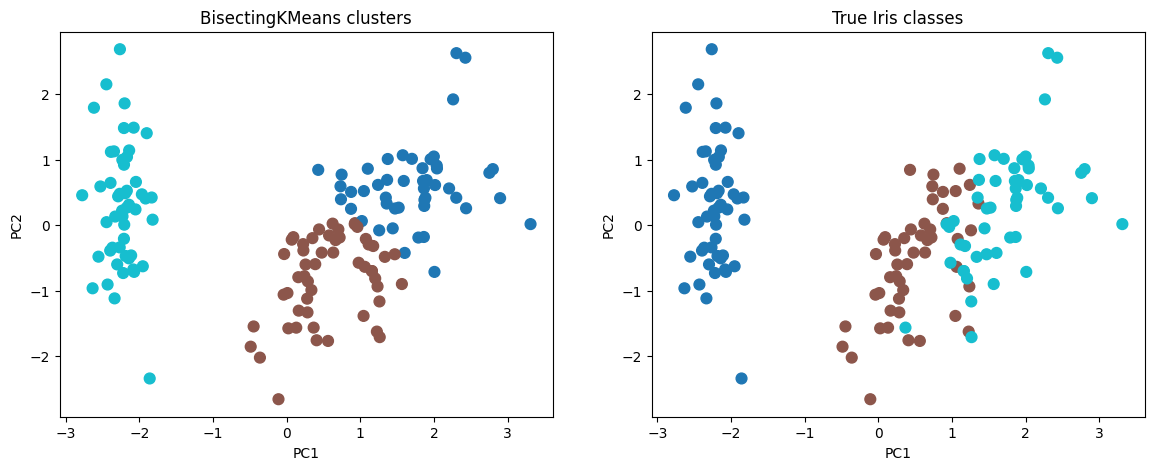

In [64]:
plt.figure(figsize=(14, 5))

#Klasteri
plt.subplot(1, 2, 1)
plt.scatter(
    X_pca[:, 0],
    X_pca[:, 1],
    c=labels,
    cmap="tab10",
    s=60
)
plt.title("BisectingKMeans clusters")
plt.xlabel("PC1")
plt.ylabel("PC2")

# Prave klase
plt.subplot(1, 2, 2)
plt.scatter(
    X_pca[:, 0],
    X_pca[:, 1],
    c=pd.Categorical(y).codes,
    cmap="tab10",
    s=60
)
plt.title("True Iris classes")
plt.xlabel("PC1")
plt.ylabel("PC2")

plt.show()


**3) Algoritmi zasnovani na gustini** - ideja je da jedan klaster cini oblast u prostoru gde je gustina tačaka visoka, dok su oblasti male gustine radvajanja između klastera.

Gustina se najčešće definiše pomoću:
- ε (epsilon) - radijus okoline (koliko daleko smatramo da nam je komšiluk)
- minPts - minimalan broj tačaka u toj okolini

Ako tačka ima dovoljno suseda u ε-okruženju, ona je u “gustoj” oblasti.

Kod density-based algoritama razlikujemo:
- Core (jezgro) = ima ≥ minPts tačaka u ε-okruženju i sigurno pripada klasteru
- Border (ivica) = nema dovoljno suseda, ali je u ε-okruženju neke core tačke
- Noise (šum / outlier) = nije ni core ni border i ne pripada niti jednom klasteru

prednosti: klasteri mogu biti proizvoljnog oblika, ne zahtevaju broj klastera unapred i ne dodeljuju svaku tačku nekom klasteru što rezultira time da mogu lako detektovati outliere

problemi: osetljivost na parametre, teško skalirati u velikim dimenzijama i kada nema jasno definisanih gustih oblasti, posebno kada su klasteri slične gustine, ali blizu

**DBSCAN**
1) Krene kroz tačke redom.
2) Ako nađe neposećenu core tačku onda otvara novi klaster.
3) U taj klaster ubaci sve tačke iz njenog ε-neighborhood.
4) Za svaku od tih tačaka:
    - ako je core, proširi klaster (dodaje njen ε-neighborhood)
    - ako je border, samo ostaje u klasteru
5) Kad više nema novih tačaka za širenje tada je klaster gotov.
6) Tačke koje nikad nisu “uhvaćene” ostaju noise (-1).

In [75]:
from sklearn.preprocessing import StandardScaler
X_scaled = StandardScaler().fit_transform(X)

In [45]:
from sklearn.cluster import DBSCAN
# Testirati grid search za pronalaženje optimalnijih parametara
db = DBSCAN(eps=0.9, min_samples=5)
_ = db.fit(X_scaled)

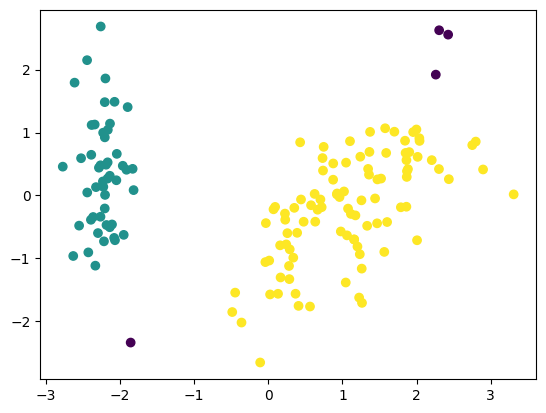

In [46]:
# Tamne tačke označavaju elemente van granica
_ = plt.scatter(X_pca[:, 0], X_pca[:, 1], c=db.labels_)

**DBSCAN++** nije jedan strogo standardizovan algoritam kao K-Means++, već predstavlja skup različitih ideja koje pokušavaju da reše problem biranja prametra ε (eps). Na primer umesto jednog globalnog eps-a svaka tačka ima svoj lokalni eps gde gusti regioni imaju manji eps dok ređi regioni imaju veći eps.

**HDBSCAN (Hierarchical DBSCAN)**:
1) gradi hijerarhiju klastera za sve eps vrednosti
2) meri stabilnost klastera (stabilnost se ogleda u tome da gust klaster prezivljava dugo kako povecavamo eps, dok reci klasteri prezivljavju kratko kako eps povecavamo)
3) zadržava samo najstabilnije klastere
4) ostalo označava kao noise

https://www.youtube.com/watch?v=dGsxd67IFiU

parametri:
- min_cluster_size = koliko klaster mora biti velik (ako neka grupa ima manje od k tacaka, ne moze formirati klaster) - odgovara na pitanje „Da li je ova grupa dovoljno VELIKA?“
- min_samples = koliko gust klaster mora bit (koliko tačaka mora biti blizu da bi tačka bila “core”) - odgovara na piitanje „Da li je ova grupa dovoljno GUSTA?“

In [89]:
from sklearn.preprocessing import StandardScaler

X_scaled = StandardScaler().fit_transform(X)

In [104]:
#! pip install hdbscan
import hdbscan
clusterer = hdbscan.HDBSCAN(
    min_cluster_size=30,   # minimalna veličina klastera
    min_samples=None,      # ako je None onda je  podrazumevano = min_cluster_size
    metric="euclidean"     # može i druge metrike
)
labels = clusterer.fit_predict(X_scaled)

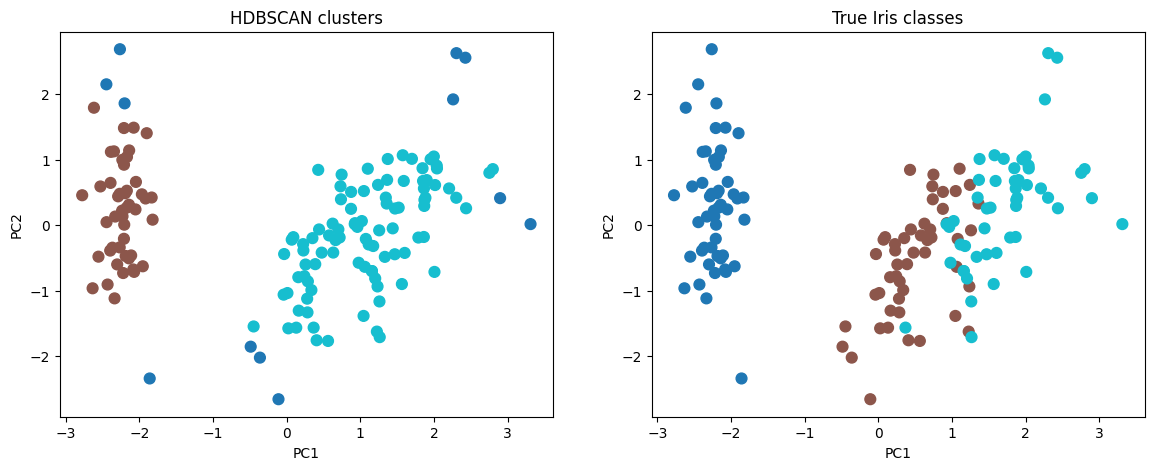

In [105]:
plt.figure(figsize=(14, 5))

#Klasteri
plt.subplot(1, 2, 1)
plt.scatter(
    X_pca[:, 0],
    X_pca[:, 1],
    c=labels,
    cmap="tab10",
    s=60
)
plt.title("HDBSCAN clusters")
plt.xlabel("PC1")
plt.ylabel("PC2")

# Prave klase
plt.subplot(1, 2, 2)
plt.scatter(
    X_pca[:, 0],
    X_pca[:, 1],
    c=pd.Categorical(y).codes,
    cmap="tab10",
    s=60
)
plt.title("True Iris classes")
plt.xlabel("PC1")
plt.ylabel("PC2")

plt.show()


In [110]:
df = iris_df.copy()
df["cluster_hdbscan"] = labels
df["cluster_hdbscan"].value_counts()

cluster_hdbscan
 1    92
 0    46
-1    12
Name: count, dtype: int64

In [111]:
df["hdbscan_prob"] = clusterer.probabilities_ #HDBSCAN daje i verovatnoću pripadnosti klasteru (za tačke koje nisu noise):
                                                # gde verovatnoca blizu 1 znaci da tacka je skoror sigurno u klasteru
df[["cluster_hdbscan", "hdbscan_prob"]].head(10)

,cluster_hdbscan,hdbscan_prob
0,0,1.000000
1,0,0.958937
2,0,1.000000
3,0,0.977386
4,0,1.000000
5,0,0.807896
6,0,1.000000
7,0,1.000000
8,0,0.701770
9,0,1.000000


**OPTICS (Ordering Points To Identify the Clustering Structure)** - je algoritam koji bolje radi d DBSCAN-a kada imamo klastere razlicitih gustina, jer pokusava da izbegne "jedan eps za sve".

pojmovi:
- *core_distance(p)* za tacku p i parametar min_samples = k je udaljenost od k-tog najblizeg suseda od p (u gustom regionu je k-ti najblizi sused blizu pa je core_distance(p) mala dok u redjem regionu je veca, a specijalno ako tačka nema dovoljno suseda u zadatom maksimumu pretrage core_distance može biti “nepostojeća” (∞))
- *reachability_distance(p | o)* je udaljenost kojom “o” (neka već obrađena tačka) “dostiže” tačku p tj po formuli *reachability(p∣o)=max(core_distance(o),d(o,p))* sto znaci da ako je o u gustom regionu (core_distance mala), onda je reachability uglavnom d(o,p), a ako je o u ređem regionu (core_distance velika), tada je “teže” da o poveže druge tačke i reachability raste.


algoritam (gde su min_samples = k i max_eps (gornja granica pretrage komšiluka)):
1) Sve tačke su neobrađene i za sve tačke reachability je inicijalno ∞ (nepoznato).
2) Izaberi neku neobrađenu tačku p (start), obeleži je kao obrađenu i dodaj u ordering.
3) Izračunaj core_distance(p) (udaljenost do k-tog suseda).
4) Ako je p core tačka (ima dovoljno suseda) onda za svakog suseda q iz p-okoline:
   - izračunaj kandidata reachability(q|p) = max(core_distance(p), d(p,q))
   - ako je to manje od trenutne reachability vrednosti za q, ažuriraj je
sve takve susede q ubaci u “prioritetnu strukturu” (min-heap) po najmanjoj reachability vrednosti.
5) Uzmi sledeću tačku iz heap-a (onu sa najmanjom reachability), nazovi je p i ponovi 2–4.
6) Kad heap postane prazan, znači da si “završio” jednu gustinsku oblast.
Onda uzmeš sledeću neobrađenu tačku i ponoviš, dok ne obradiš sve.

Rezultat algoritma je "Reachability plot" na kome je na x-osi dobijeni redosled obradjenih tacaka iz OPTICS-a, a na y-osi reachability distance
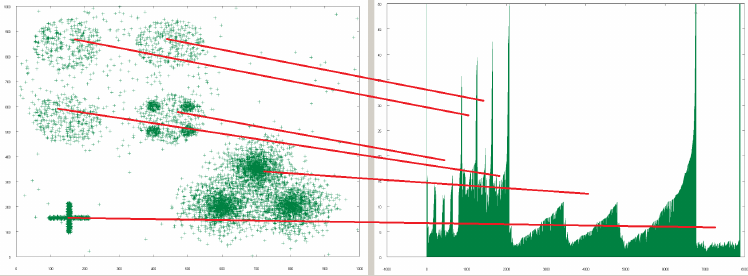

In [112]:
from sklearn.cluster import OPTICS

optics = OPTICS(
    min_samples=5,      # isto značenje kao u DBSCAN-u
    max_eps=np.inf,     # razmatraj sve distance
    xi=0.05,            # koristi se ako kasnije želiš Xi extraction
    min_cluster_size=0.05  # može i procenat (5%) ili int
)

optics.fit(X_scaled)

,"min_samples min_samples: int > 1 or float between 0 and 1, default=5The number of samples in a neighborhood for a point to be considered asa core point. Also, up and down steep regions can't have more than``min_samples`` consecutive non-steep points. Expressed as an absolutenumber or a fraction of the number of samples (rounded to be at least2).",5
,"max_eps max_eps: float, default=np.infThe maximum distance between two samples for one to be considered asin the neighborhood of the other. Default value of ``np.inf`` willidentify clusters across all scales; reducing ``max_eps`` will resultin shorter run times.",inf
,"metric metric: str or callable, default='minkowski'Metric to use for distance computation. Any metric from scikit-learnor :mod:`scipy.spatial.distance` can be used.If `metric` is a callable function, it is called on eachpair of instances (rows) and the resulting value recorded. The callableshould take two arrays as input and return one value indicating thedistance between them. This works for Scipy's metrics, but is lessefficient than passing the metric name as a string. If metric is""precomputed"", `X` is assumed to be a distance matrix and must besquare.Valid values for metric are:- from scikit-learn: ['cityblock', 'cosine', 'euclidean', 'l1', 'l2', 'manhattan']- from scipy.spatial.distance: ['braycurtis', 'canberra', 'chebyshev', 'correlation', 'dice', 'hamming', 'jaccard', 'kulsinski', 'mahalanobis', 'minkowski', 'rogerstanimoto', 'russellrao', 'seuclidean', 'sokalmichener', 'sokalsneath', 'sqeuclidean', 'yule']Sparse matrices are only supported by scikit-learn metrics.See :mod:`scipy.spatial.distance` for details on these metrics... note:: `'kulsinski'` is deprecated from SciPy 1.9 and will be removed in SciPy 1.11.",'minkowski'
,"p p: float, default=2Parameter for the Minkowski metric from:class:`~sklearn.metrics.pairwise_distances`. When p = 1, this isequivalent to using manhattan_distance (l1), and euclidean_distance(l2) for p = 2. For arbitrary p, minkowski_distance (l_p) is used.",2
,"metric_params metric_params: dict, default=NoneAdditional keyword arguments for the metric function.",None
,"cluster_method cluster_method: {'xi', 'dbscan'}, default='xi'The extraction method used to extract clusters using the calculatedreachability and ordering.",'xi'
,"eps eps: float, default=NoneThe maximum distance between two samples for one to be considered asin the neighborhood of the other. By default it assumes the same valueas ``max_eps``.Used only when ``cluster_method='dbscan'``.",None
,"xi xi: float between 0 and 1, default=0.05Determines the minimum steepness on the reachability plot thatconstitutes a cluster boundary. For example, an upwards point in thereachability plot is defined by the ratio from one point to itssuccessor being at most 1-xi.Used only when ``cluster_method='xi'``.",0.05
,"predecessor_correction predecessor_correction: bool, default=TrueCorrect clusters according to the predecessors calculated by OPTICS[2]_. This parameter has minimal effect on most datasets.Used only when ``cluster_method='xi'``.",True
,"min_cluster_size min_cluster_size: int > 1 or float between 0 and 1, default=NoneMinimum number of samples in an OPTICS cluster, expressed as anabsolute number or a fraction of the number of samples (rounded to beat least 2). If ``None``, the value of ``min_samples`` is used instead.Used only when ``cluster_method='xi'``.",0.05
,"algorithm algorithm: {'auto', 'ball_tree', 'kd_tree', 'brute'}, default='auto'Algorithm used to compute the nearest neighbors:- 'ball_tree' will use :class:`~sklearn.neighbors.BallTree`.- 'kd_tree' will use :class:`~sklearn.neighbors.KDTree`.- 'brute' will use a brute-force search.- 'auto' (default) will attempt to decide the most appropriate algorithm based on the values passed to :meth:`fit` method.Note: fitting on sparse input will override the setting ofthis parameter, using brute force.",'auto'


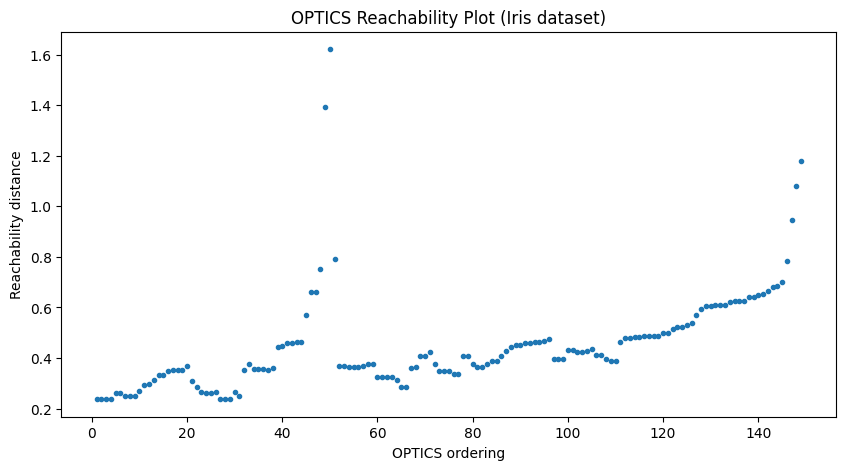

In [114]:
import matplotlib.pyplot as plt

ordering = optics.ordering_ # redosled indeksa tačaka u kome ih je OPTICS obradio.
reachability = optics.reachability_[ordering] # niz gde optics.reachability_[i] predstavlja reachability distance tačke sa indeksom i u ORIGINALNOM redosledu podataka
plt.figure(figsize=(10, 5))
plt.plot(reachability, marker='.', linestyle='none')
plt.xlabel("OPTICS ordering")
plt.ylabel("Reachability distance")
plt.title("OPTICS Reachability Plot (Iris dataset)")
plt.show()


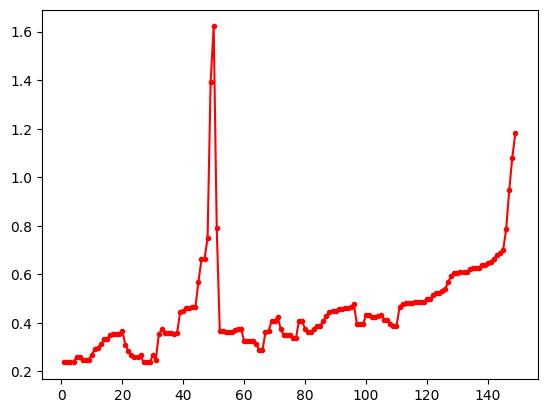

In [115]:
plt.plot(range(len(reachability)),reachability,color='r',marker='o',markersize=3)

- nizak reachability → tačke su u gustim regionima (unutar klastera)
- skokovi / visoke vrednosti → prelazi između klastera ili šum

Kako se iz OPTICS izlaza dobiju klasteri?

A) DBSCAN extraction -  gde se izabere eps = npr. 0.5 i sve tačke sa reachability < eps i koje su povezane cine klaster

In [116]:
from sklearn.cluster import cluster_optics_dbscan
eps = 0.8  # probati više vrednosti (npr. 0.5, 0.8, 1.0) nakon skaliranja

labels_dbscan = cluster_optics_dbscan(
    reachability=optics.reachability_,
    core_distances=optics.core_distances_,
    ordering=optics.ordering_,
    eps=eps
)
df["cluster_optics_dbscan"] = labels_dbscan
df["cluster_optics_dbscan"].value_counts()

cluster_optics_dbscan
 1    97
 0    49
-1     4
Name: count, dtype: int64

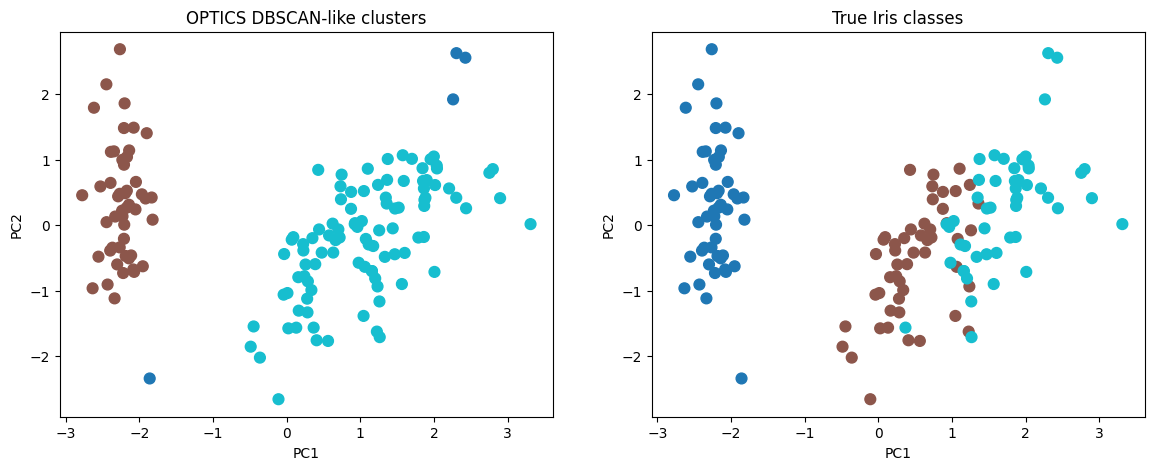

In [117]:
plt.figure(figsize=(14, 5))

#Klasteri
plt.subplot(1, 2, 1)
plt.scatter(
    X_pca[:, 0],
    X_pca[:, 1],
    c=labels_dbscan,
    cmap="tab10",
    s=60
)
plt.title("OPTICS DBSCAN-like clusters")
plt.xlabel("PC1")
plt.ylabel("PC2")

# Prave klase
plt.subplot(1, 2, 2)
plt.scatter(
    X_pca[:, 0],
    X_pca[:, 1],
    c=pd.Categorical(y).codes,
    cmap="tab10",
    s=60
)
plt.title("True Iris classes")
plt.xlabel("PC1")
plt.ylabel("PC2")

plt.show()


B) Xi metoda (xi) - automatski traži nagla povećanja reachability i “seče” ordering tamo gde gustina naglo opada

In [118]:
labels_xi = optics.labels_ # posto smo prosledili xi i min_cluster_size parametre
                        # onda nam labeledirektno predstavljaju one iz Xi extraction-a
                        # dodatno se moze proslediti i parametar modelu cluster_method="xi"

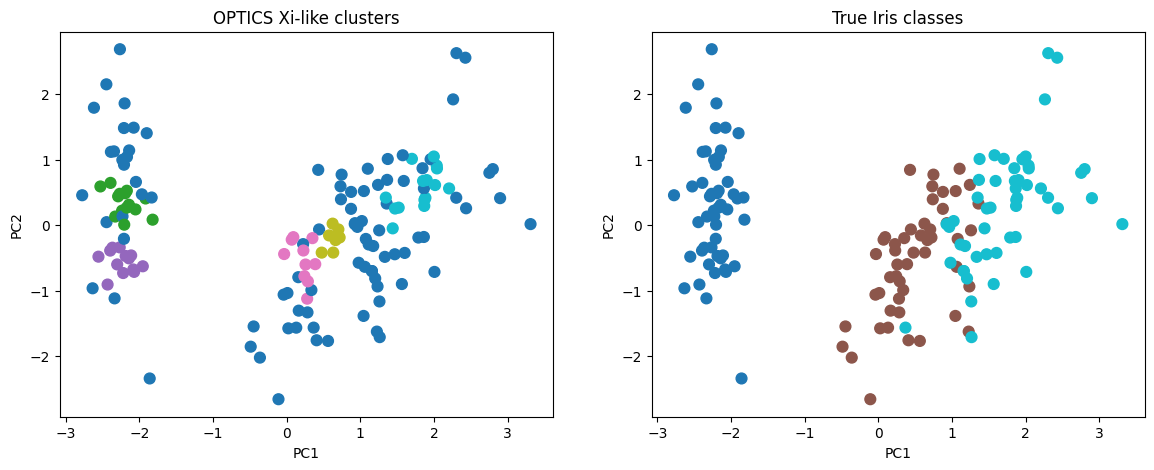

In [119]:
plt.figure(figsize=(14, 5))

#Klasteri
plt.subplot(1, 2, 1)
plt.scatter(
    X_pca[:, 0],
    X_pca[:, 1],
    c=labels_xi,
    cmap="tab10",
    s=60
)
plt.title("OPTICS Xi-like clusters")
plt.xlabel("PC1")
plt.ylabel("PC2")

# Prave klase
plt.subplot(1, 2, 2)
plt.scatter(
    X_pca[:, 0],
    X_pca[:, 1],
    c=pd.Categorical(y).codes,
    cmap="tab10",
    s=60
)
plt.title("True Iris classes")
plt.xlabel("PC1")
plt.ylabel("PC2")

plt.show()
